<a href="https://colab.research.google.com/github/aarsh121/Financial-Analysis-using-Python/blob/main/Satellite_Maneuvers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Satellite Control Room !!
**Here we will learn methods to detect Satellite Maneuvers**

**Importing Libraries**

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

##1- Heuristic Method

**Loading the Dataset**

In [88]:
data = pd.read_csv('SMA_data.csv', parse_dates=['Datetime'])
data.dtypes

,0
Datetime,datetime64[ns]
SMA,float64


### 1.1- Detection Based on Speed Change



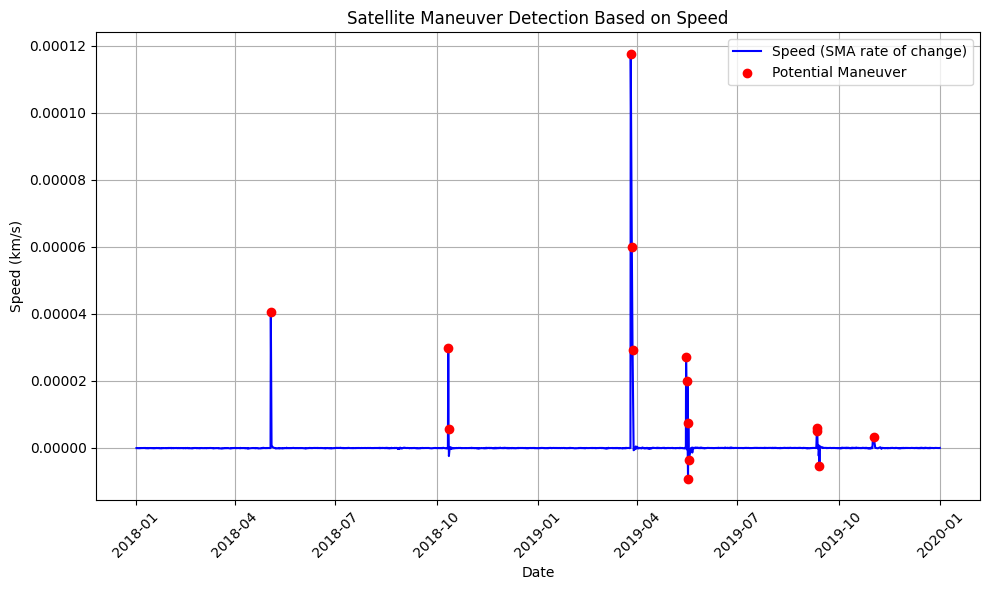

In [89]:
# Difference between consecutive points in seconds
data['Time_Diff'] = data['Datetime'].diff().dt.total_seconds()

# Difference in SMA between consecutive points
data['SMA_Diff'] = data['SMA'].diff()

# Calculating the speed (SMA change per time unit)
data['Speed'] = data['SMA_Diff'] / data['Time_Diff']

# Plot the speed over time to visualize potential anomalies
plt.figure(figsize=(10, 6))
plt.plot(data['Datetime'], data['Speed'], label='Speed (SMA rate of change)', color='b')
plt.title('Satellite Maneuver Detection Based on Speed')
plt.xlabel('Date')
plt.ylabel('Speed (km/s)')
plt.legend()
plt.grid(True)

# Highlighting possible maneuvers where significant speed differences occur
maneuvers = data[np.abs(data['Speed']) > data['Speed'].std()] #We can experiment with diff std
plt.scatter(maneuvers['Datetime'], maneuvers['Speed'], color='r', label='Potential Maneuver', zorder=5)

plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [116]:
# Displaying the dates where maneuvers were likely to have occurred
maneuver_dates_speed = maneuvers['Datetime']
maneuver_dates_speed.head()


,Datetime
384,2018-05-03 12:01:31.056960
871,2018-10-11 13:37:04.556640
872,2018-10-11 19:59:53.915424
1421,2019-03-26 04:53:33.243936
1422,2019-03-27 04:34:36.436800


### 1.2- Detection Based on Change in SMA

In [91]:
# Set a threshold for detecting significant changes in the semi-major axis
threshold = data['SMA_Diff'].std() * 2  # Two standard deviations from the mean

# Detect maneuvers: Mark points where the change in SMA exceeds the threshold
data['Maneuver'] = np.abs(data['SMA_Diff']) > threshold


In [92]:
maneuver_dates_SMA = data[data['Maneuver']]['Datetime']

print("Detected Maneuver Dates:")
for date in maneuver_dates_SMA:
    print(date)

Detected Maneuver Dates:
2018-05-03 12:01:31.056960
2018-10-11 13:37:04.556640
2019-03-26 04:53:33.243936
2019-03-27 04:34:36.436800
2019-03-27 20:25:37.599168
2019-05-15 10:44:36.864096
2019-05-17 05:11:39.372288
2019-09-11 04:28:22.151136


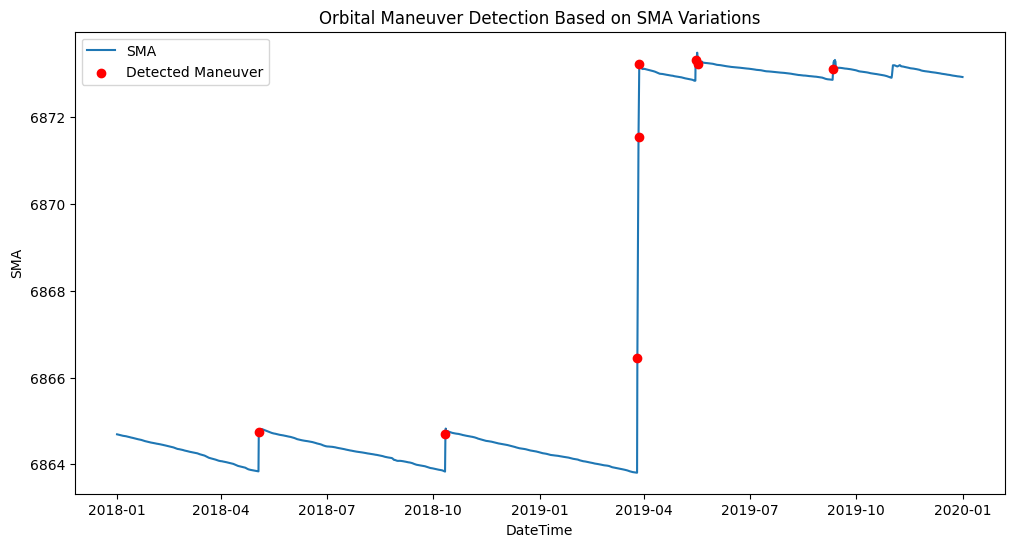

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(data['Datetime'], data['SMA'], label='SMA')

# Plotting detected maneuvers
plt.scatter(maneuver_dates_SMA, data[data['Maneuver']]['SMA'], color='red', label='Detected Maneuver', zorder=5)

plt.xlabel('DateTime')
plt.ylabel('SMA')
plt.title('Orbital Maneuver Detection Based on SMA Variations')
plt.legend()
plt.show()

##2- Random Forest ML Model

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [95]:
data = pd.read_csv('SMA_data.csv', parse_dates=['Datetime'])

In [96]:
# Feature Engineering: Compute the difference in SMA between consecutive timestamps
data['SMA_diff'] = data['SMA'].diff()
data['SMA_diff_shift'] = data['SMA_diff'].shift(-1)
data.head()

,Datetime,SMA,SMA_diff,SMA_diff_shift
0,2018-01-01 04:34:10.320672,6864.691463,NaN,-0.001799
1,2018-01-01 12:37:36.596064,6864.689664,-0.001799,-0.001079
2,2018-01-01 20:31:55.898112,6864.688585,-0.001079,-0.003658
3,2018-01-02 05:42:49.014720,6864.684927,-0.003658,-0.002069
4,2018-01-02 12:13:01.263360,6864.682858,-0.002069,-0.001589


In [97]:
threshold = data['SMA_diff'].std() * 1.5
print(f"Threshold for detecting maneuvers: {threshold}")

Threshold for detecting maneuvers: 0.19311791681297671


In [98]:
# Create labels: Maneuver (1) if change exceeds threshold, else No Maneuver (0)
data['Label'] = (np.abs(data['SMA_diff']) > threshold).astype(int)

# Drop rows with NaN values (first row due to diff)
data = data.dropna()


In [99]:
# Check the distribution of labels (imbalanced data check)
print("Label Distribution (0 = No Maneuver, 1 = Maneuver):")
print(data['Label'].value_counts())


Label Distribution (0 = No Maneuver, 1 = Maneuver):
Label
0    2279
1      10
Name: count, dtype: int64


**We can see it has detected 10 Maneuvers. Most of the labels are 0, which makes the dataset imbalance and this result in overfitting of the model. As we increase threshold the number of maneuvers will decrease.**

In [100]:
# Defining (X) and target labels (y)
X = data[['SMA', 'SMA_diff', 'SMA_diff_shift']]
y = data['Label']

# Split data into training (50%) and testing sets (50%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predictions on the test set
y_pred = rf.predict(X_test)

In [101]:
# Evaluate the model on the test set
print("Accuracy Score on Test Set:", accuracy_score(y_test, y_pred))
print("Classification Report on Test Set:\n", classification_report(y_test, y_pred))

# Confusion Matrix to better understand the performance
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy Score on Test Set: 0.9985443959243085
Classification Report on Test Set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       683
           1       1.00      0.75      0.86         4

    accuracy                           1.00       687
   macro avg       1.00      0.88      0.93       687
weighted avg       1.00      1.00      1.00       687

Confusion Matrix:
 [[683   0]
 [  1   3]]


**We are getting accuracy of 99%. So the model is overfitting. To reduce overfitting we can perform some hyperparameter tuning like- Increase test size, change standard deviation, or add more data to balance the dataset.**

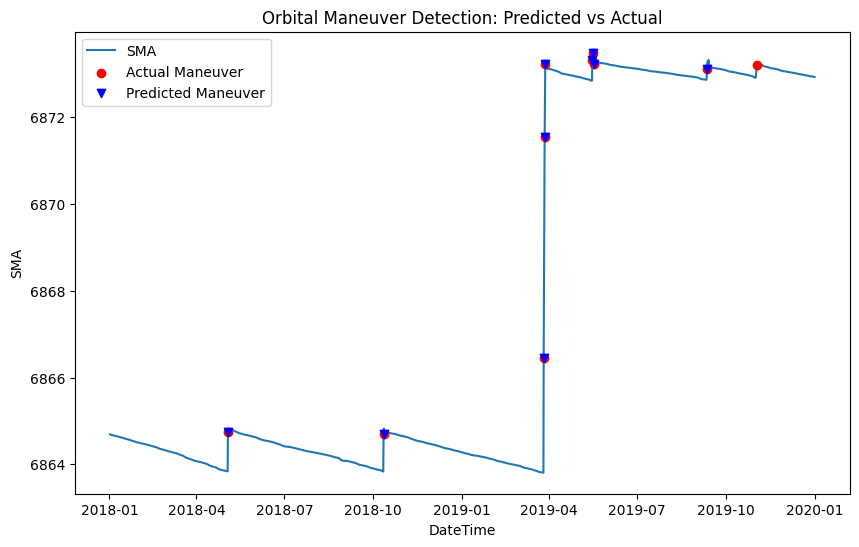

In [102]:
# Ploting Graph
data['Predicted_Label'] = rf.predict(X)

plt.figure(figsize=(10, 6))
plt.plot(data['Datetime'], data['SMA'], label='SMA')

plt.scatter(data[data['Label'] == 1]['Datetime'], data[data['Label'] == 1]['SMA'], color='red', label='Actual Maneuver', zorder=5)
plt.scatter(data[data['Predicted_Label'] == 1]['Datetime'], data[data['Predicted_Label'] == 1]['SMA'], marker='v', color='blue', label='Predicted Maneuver', zorder=5)

plt.xlabel('DateTime')
plt.ylabel('SMA')
plt.title('Orbital Maneuver Detection: Predicted vs Actual')
plt.legend()
plt.show()


In [119]:
maneuver_dates_ML = data[data['Label'] == 1]['Datetime']

print("Detected Maneuver Dates:")
for date in maneuver_dates_ML:
    print(date)

Detected Maneuver Dates:
2018-05-03 12:01:31.056960
2018-10-11 13:37:04.556640
2019-03-26 04:53:33.243936
2019-03-27 04:34:36.436800
2019-03-27 20:25:37.599168
2019-05-15 10:44:36.864096
2019-05-16 16:43:16.023072
2019-05-17 05:11:39.372288
2019-09-11 04:28:22.151136
2019-11-01 17:55:22.162656


##Conclusion
**Below are the comaprison between maneuvers predicted date by different methods**

In [118]:
#Dates from SMA
maneuver_dates_ML= pd.to_datetime(maneuver_dates_ML)
maneuver_dates_SMA= pd.to_datetime(maneuver_dates_SMA)
maneuver_dates_speed= pd.to_datetime(maneuver_dates_speed)
#Dates from Speed
maneuver_dates_ML= maneuver_dates_ML.dt.strftime('%Y-%m-%d')
maneuver_dates_SMA= maneuver_dates_SMA.dt.strftime('%Y-%m-%d')
maneuver_dates_speed= maneuver_dates_speed.dt.strftime('%Y-%m-%d')

comparison_df = pd.DataFrame({
    'ML Model Dates': maneuver_dates_ML,
    'SMA Dates': maneuver_dates_SMA,
    'Speed Dates': maneuver_dates_speed
})
comparison_df

,ML Model Dates,SMA Dates,Speed Dates
384,2018-05-03,2018-05-03,2018-05-03
871,2018-10-11,2018-10-11,2018-10-11
872,NaN,NaN,2018-10-11
1421,2019-03-26,2019-03-26,2019-03-26
1422,2019-03-27,2019-03-27,2019-03-27
1423,2019-03-27,2019-03-27,2019-03-27
1583,2019-05-15,2019-05-15,2019-05-15
1585,2019-05-16,NaN,2019-05-16
1587,2019-05-17,2019-05-17,2019-05-17
1588,NaN,NaN,2019-05-17


**We can see detecting based on only change in SMA is gives lots of maneuvers dates, which might incorrect. We can conclude Random Forest and Variation in speed methods have performed well.**